# Churn Prediction Pipeline
This notebook implements churn prediction using Logistic Regression and Decision Tree classifiers.

In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.ensemble import RandomForestClassifier




In [59]:
# Load cleaned customer-level data
df = pd.read_csv("../data/cleaned_customer_data.csv")
df.head()
df.columns

Index(['sale_id', 'customer_id', 'product_id', 'product_name', 'category',
       'price', 'quantity', 'sale_date', 'total_value', 'age', 'gender',
       'region', 'segment', 'churn', 'tenure_months', 'last_purchase_date',
       'feedback_text', 'sentiment', 'month', 'year', 'quarter'],
      dtype='object')

In [60]:
# Convert dates to datetime
df['sale_date'] = pd.to_datetime(df['sale_date'])
df = df.sort_values(by=['customer_id', 'sale_date'])

# Create dynamic last purchase date (previous transaction date)
df['adjusted_last_purchase_date'] = df.groupby('customer_id')['sale_date'].shift(1)

# Fill missing values with sale_date (first transaction for customer)
df['adjusted_last_purchase_date'] = df['adjusted_last_purchase_date'].fillna(df['sale_date'])

# Calculate recency in days
df['recency_days'] = (df['sale_date'] - df['adjusted_last_purchase_date']).dt.days


In [61]:
# Period helpers
df["month"] = df["sale_date"].dt.to_period("M").astype(str)
df["quarter"] = df["sale_date"].dt.to_period("Q").astype(str)
df["is_q4"] = df["sale_date"].dt.quarter.eq(4).astype(int)

# Feedback helpers
# Map sentiment strings to numeric score: pos=+1, neu=0, neg=-1 (adjust if your labels differ)
sent_map = { "positive": 1, "neutral": 0, "negative": -1}
df["sentiment_score"] = df["sentiment"].str.lower().map(sent_map).fillna(0)

# Count a feedback if there's non-empty text
df["has_feedback"] = df["feedback_text"].fillna("").str.strip().ne("").astype(int)
df["is_negative_feedback"] = (df["sentiment_score"] < 0).astype(int)


df

,sale_id,customer_id,product_id,product_name,category,price,quantity,sale_date,total_value,age,...,sentiment,month,year,quarter,adjusted_last_purchase_date,recency_days,is_q4,sentiment_score,has_feedback,is_negative_feedback
2443,S003108,CUST00001,P004,Desk,Furniture,12000,2,2023-05-19,24000,43,...,Neutral,2023-05,2023,2023Q2,2023-05-19,0,0,0,1,0
2988,S003819,CUST00002,P006,Notebook,Office Supplies,100,3,2022-01-19,300,22,...,Positive,2022-01,2022,2022Q1,2022-01-19,0,0,1,1,0
6058,S007788,CUST00002,P009,Monitor,Electronics,12000,2,2022-10-07,24000,22,...,Positive,2022-10,2022,2022Q4,2022-01-19,261,1,1,1,0
390,S000494,CUST00002,P004,Desk,Furniture,12000,3,2023-02-22,36000,22,...,Negative,2023-02,2023,2023Q1,2022-10-07,138,0,-1,1,1
4279,S005471,CUST00002,P003,Office Chair,Furniture,8000,3,2023-04-03,24000,22,...,Negative,2023-04,2023,2023Q2,2023-02-22,40,0,-1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,S000198,CUST02000,P003,Office Chair,Furniture,8000,4,2021-08-17,32000,28,...,Negative,2021-08,2021,2021Q3,2021-08-17,0,0,-1,1,1
4296,S005491,CUST02000,P009,Monitor,Electronics,12000,5,2023-02-01,60000,28,...,Negative,2023-02,2023,2023Q1,2021-08-17,533,0,-1,1,1
3758,S004798,CUST02000,P009,Monitor,Electronics,12000,1,2023-08-15,12000,28,...,Positive,2023-08,2023,2023Q3,2023-02-01,195,0,1,1,0
2145,S002711,CUST02000,P002,Smartphone,Electronics,25000,4,2023-08-27,100000,28,...,Positive,2023-08,2023,2023Q3,2023-08-15,12,0,1,1,0


In [62]:
# Helper to compute std of inter-purchase gaps (skip 0s from first/duplicated)
def order_variability_func(x):
    x = x.dropna()
    # Remove zeros (first purchase recency is 0 by construction)
    x = x[x > 0]
    return x.std() if len(x) > 1 else 0.0

# Helper to compute purchase trend (slope of monthly spend over time)
def purchase_trend_func(sub_df):
    # Sum spend by month for that customer
    s = sub_df.groupby(sub_df["sale_date"].dt.to_period("M"))["total_value"].sum().astype(float)
    if len(s) < 2:
        return 0.0
    # Fit a straight line: index 0..n-1 vs monthly spend
    x = np.arange(len(s))
    slope = np.polyfit(x, s.values, 1)[0]
    return float(slope)

# Aggregate
cust = df.groupby("customer_id").apply(
    lambda g: pd.Series({
        # Behavior
        "total_spend": g["total_value"].sum(),
        "total_quantity": g["quantity"].sum(),
        "purchase_count": g["sale_id"].nunique(),   # or len(g)

        # Timing
        "first_purchase_date": g["sale_date"].min(),
        "last_purchase_date_calc": g["sale_date"].max(),
        "avg_recency_days": g["recency_days"].mean(),
        "order_variability": order_variability_func(g["recency_days"]),

        # Diversity
        "product_diversity": g["product_id"].nunique(),
        "category_diversity": g["category"].nunique(),
        #"repeat_product_ratio": 1.0 - (g["product_id"].nunique() / max(g["sale_id"].nunique(), 1)),

        # Q4 / seasonal
        "seasonal_purchase_ratio": g["is_q4"].mean(),

        # Feedback
        "avg_sentiment_score": g["sentiment_score"].mean(),
        "negative_feedback_count": g["is_negative_feedback"].sum(),


        # Demographics / labels (take first non-null)
        "age": g["age"].dropna().iloc[0] if g["age"].notna().any() else np.nan,
        "gender": g["gender"].dropna().iloc[0] if g["gender"].notna().any() else np.nan,
        "region": g["region"].dropna().iloc[0] if g["region"].notna().any() else np.nan,
        "segment": g["segment"].dropna().iloc[0] if g["segment"].notna().any() else np.nan,
        "tenure_months": g["tenure_months"].dropna().iloc[0] if g["tenure_months"].notna().any() else np.nan,
        "churn": g["churn"].dropna().iloc[0] if g["churn"].notna().any() else np.nan,

        # Advanced: slope of monthly spend
        "purchase_trend": purchase_trend_func(g),
    })
).reset_index()

# Derived behavior
cust["avg_order_value"] = cust["total_spend"] / cust["purchase_count"].replace(0, np.nan)
cust["avg_items_per_purchase"] = cust["total_quantity"] / cust["purchase_count"].replace(0, np.nan)

reference_date = pd.to_datetime("2024-01-01")

# Days since last purchase (relative to dataset max date)
cust["days_since_last_purchase"] = (reference_date - cust["last_purchase_date_calc"]).dt.days

# Purchase span (time between first & last)
cust["time_between_first_last_purchase"] = (cust["last_purchase_date_calc"] - cust["first_purchase_date"]).dt.days.clip(lower=0)

# Frequency flavors
# 1) Mean inter-purchase gap (already have avg_recency_days)
# 2) Purchases per month over active span
months_active = (cust["time_between_first_last_purchase"] / 30.0).replace(0, np.nan)
cust["purchases_per_month"] = cust["purchase_count"] / months_active


/var/folders/zt/wczhdn1s3_n_3tj8j25wrpgm0000gn/T/ipykernel_2911/157818902.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cust = df.groupby("customer_id").apply(


In [63]:
cust

,customer_id,total_spend,total_quantity,purchase_count,first_purchase_date,last_purchase_date_calc,avg_recency_days,order_variability,product_diversity,category_diversity,...,region,segment,tenure_months,churn,purchase_trend,avg_order_value,avg_items_per_purchase,days_since_last_purchase,time_between_first_last_purchase,purchases_per_month
0,CUST00001,24000,2,1,2023-05-19,2023-05-19,0.000000,0.000000,1,1,...,South,Corporate,50,0,0.0,24000.0,2.000000,227,0,NaN
1,CUST00002,84300,11,4,2022-01-19,2023-04-03,109.750000,110.735420,4,3,...,East,Corporate,37,1,8310.0,21075.0,2.750000,273,439,0.273349
2,CUST00003,130150,14,4,2020-07-18,2023-05-03,254.750000,126.040999,3,3,...,North,Corporate,18,0,13955.0,32537.5,3.500000,243,1019,0.117763
3,CUST00004,69000,8,3,2021-08-28,2022-10-02,133.333333,82.024387,3,2,...,East,Consumer,3,0,1500.0,23000.0,2.666667,456,400,0.225000
4,CUST00005,8000,1,1,2021-10-11,2021-10-11,0.000000,0.000000,1,1,...,West,Corporate,45,0,0.0,8000.0,1.000000,812,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1910,CUST01995,300,3,1,2020-02-07,2020-02-07,0.000000,0.000000,1,1,...,West,Consumer,31,0,0.0,300.0,3.000000,1424,0,NaN
1911,CUST01997,120500,17,5,2020-03-10,2023-03-30,223.000000,230.282978,4,3,...,West,Small Business,19,1,6250.0,24100.0,3.400000,277,1115,0.134529
1912,CUST01998,3000,1,1,2020-04-26,2020-04-26,0.000000,0.000000,1,1,...,East,Consumer,54,0,0.0,3000.0,1.000000,1345,0,NaN
1913,CUST01999,45300,9,3,2020-08-28,2023-03-04,306.000000,254.558441,3,2,...,East,Small Business,31,0,-13500.0,15100.0,3.000000,303,918,0.098039


In [64]:
# CLV proxy: use total_spend * purchases_per_month (bounded)
cust["CLV_estimate"] = cust["total_spend"] * cust["purchases_per_month"].fillna(0)



# Seasonal ratio already computed as share of Q4

# Engagement score (simple composite using min-max on three signals)
def minmax(s):
    s = s.astype(float)
    return (s - s.min()) / (s.max() - s.min()) if s.max() > s.min() else s*0

eng_freq = minmax(cust["purchases_per_month"].fillna(0))
eng_recency = 1 - minmax(cust["days_since_last_purchase"].fillna(cust["days_since_last_purchase"].max()))

cust["engagement_score"] = (eng_freq + eng_recency ) / 2.0

# Final cleaning: replace inf/NaN for modeling convenience
cust = cust.replace([np.inf, -np.inf], np.nan)
cust = cust.fillna({
    "avg_order_value": 0,
    "avg_items_per_purchase": 0,
    "purchases_per_month": 0,
    "CLV_estimate": 0,
    "engagement_score": 0,
})

# Keep only columns you need downstream
final_cols = [
    "customer_id",
    # Behavior
    "total_spend", "total_quantity", "avg_order_value", "avg_items_per_purchase",
    # Frequency & timing
    "avg_recency_days", "days_since_last_purchase",
    "time_between_first_last_purchase", "order_variability",
    "purchases_per_month",
    # Diversity
    "product_diversity", "category_diversity",
    # Seasonal
    "seasonal_purchase_ratio",
    # Feedback
    "avg_sentiment_score", "negative_feedback_count",
    # Advanced
    "purchase_trend", "CLV_estimate",
    # Demographics/labels
    "age", "gender", "region", "segment", "tenure_months", "churn",
]

cust_final = cust[final_cols].copy()
cust_final.head()


,customer_id,total_spend,total_quantity,avg_order_value,avg_items_per_purchase,avg_recency_days,days_since_last_purchase,time_between_first_last_purchase,order_variability,purchases_per_month,...,avg_sentiment_score,negative_feedback_count,purchase_trend,CLV_estimate,age,gender,region,segment,tenure_months,churn
0,CUST00001,24000,2,24000.0,2.000000,0.000000,227,0,0.000000,0.000000,...,0.000000,0,0.0,0.000000,43,Female,South,Corporate,50,0
1,CUST00002,84300,11,21075.0,2.750000,109.750000,273,439,110.735420,0.273349,...,0.000000,2,8310.0,23043.280182,22,Male,East,Corporate,37,1
2,CUST00003,130150,14,32537.5,3.500000,254.750000,243,1019,126.040999,0.117763,...,0.500000,1,13955.0,15326.790972,59,Female,North,Corporate,18,0
3,CUST00004,69000,8,23000.0,2.666667,133.333333,456,400,82.024387,0.225000,...,0.333333,1,1500.0,15525.000000,29,Male,East,Consumer,3,0
4,CUST00005,8000,1,8000.0,1.000000,0.000000,812,0,0.000000,0.000000,...,-1.000000,1,0.0,0.000000,53,Female,West,Corporate,45,0


In [65]:
cust_model = pd.get_dummies(cust_final, columns=["gender", "region", "segment"], drop_first=True)


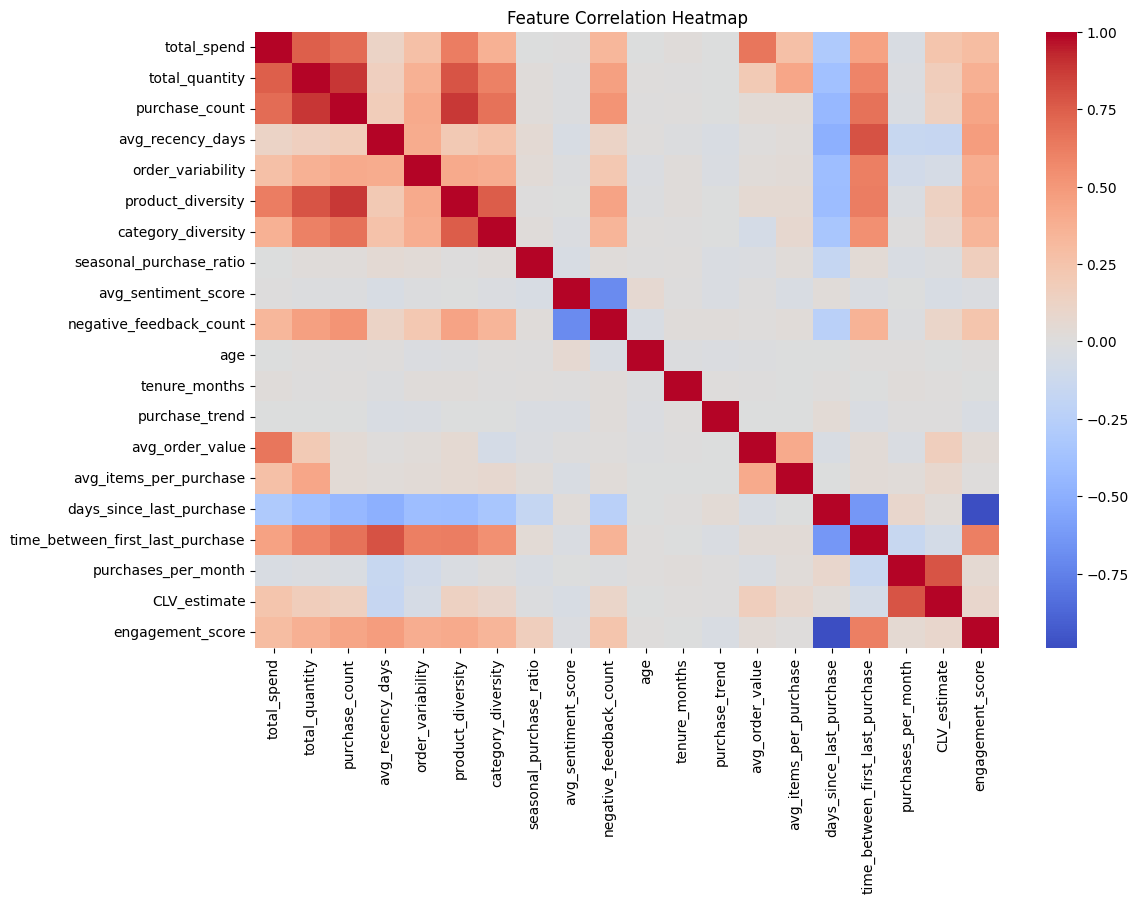

Highly correlated pairs (>0.85): [('total_quantity', 'purchase_count', 0.8876999925607753), ('purchase_count', 'total_quantity', 0.8876999925607753), ('purchase_count', 'product_diversity', 0.8794092984627861), ('product_diversity', 'purchase_count', 0.8794092984627861), ('days_since_last_purchase', 'engagement_score', -0.9894607081410182), ('engagement_score', 'days_since_last_purchase', -0.9894607081410182)]


In [66]:


# Numeric features only (exclude churn itself for correlation)
num_feats = cust.drop(columns=["churn"]).select_dtypes(include=["number"])
corr = num_feats.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# Optional: detect highly correlated features
threshold = 0.85
high_corr = [(i, j, corr.loc[i, j]) 
             for i in corr.columns for j in corr.columns 
             if i != j and abs(corr.loc[i, j]) > threshold]
print("Highly correlated pairs (>0.85):", high_corr)


In [67]:

# Features and target
X = cust_model.drop(columns=["customer_id", "churn"])  # drop IDs & target
y = cust_model["churn"].astype(int)  # ensure binary int
X = X.select_dtypes(include=["number"])  # keep only usable features

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X,y)
# Scale numeric features (important for Logistic Regression / SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


      total_spend  total_quantity  avg_order_value  avg_items_per_purchase  \
0           24000               2          24000.0                2.000000   
1           84300              11          21075.0                2.750000   
2          130150              14          32537.5                3.500000   
3           69000               8          23000.0                2.666667   
4            8000               1           8000.0                1.000000   
...           ...             ...              ...                     ...   
1910          300               3            300.0                3.000000   
1911       120500              17          24100.0                3.400000   
1912         3000               1           3000.0                1.000000   
1913        45300               9          15100.0                3.000000   
1914       264000              18          52800.0                3.600000   

      avg_recency_days  days_since_last_purchase  \
0          

In [68]:


# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_pred_log = log_reg.predict(X_test_scaled)

print("=== Logistic Regression Results ===")
print(classification_report(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))


=== Logistic Regression Results ===
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       288
           1       0.00      0.00      0.00        95

    accuracy                           0.75       383
   macro avg       0.38      0.50      0.43       383
weighted avg       0.57      0.75      0.65       383

Confusion Matrix:
 [[288   0]
 [ 95   0]]


/Users/shubhau/Documents/capstone/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shubhau/Documents/capstone/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shubhau/Documents/capstone/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [69]:
df["churn"].value_counts(normalize=True) * 100


churn
0    75.518072
1    24.481928
Name: proportion, dtype: float64

In [70]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only on training set
sm = SMOTE( random_state=42)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res.select_dtypes(include=["int64", "float64"]))
X_test_scaled  = scaler.transform(X_test.select_dtypes(include=["int64", "float64"]))



In [72]:
log_reg_smote = LogisticRegression(random_state=42, max_iter=1000,class_weight='balanced')
log_reg_smote.fit(X_train_scaled, y_train_res)

y_pred_smote = log_reg_smote.predict(X_test_scaled)

print("=== Logistic Regression with SMOTE ===")
print(classification_report(y_test, y_pred_smote))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))

=== Logistic Regression with SMOTE ===
              precision    recall  f1-score   support

           0       0.76      0.68      0.72       288
           1       0.26      0.35      0.30        95

    accuracy                           0.60       383
   macro avg       0.51      0.51      0.51       383
weighted avg       0.64      0.60      0.61       383

Confusion Matrix:
 [[196  92]
 [ 62  33]]


In [73]:
# Count class distribution
print(y_train_res.value_counts())

# Get proportions
print(y_train_res.value_counts(normalize=True))

# If you only want churn rate (% of class 1)
churn_rate = (y_train_res == 1).mean()
print(f"Churn rate in y_train_res: {churn_rate:.2%}")

churn
1    1153
0    1153
Name: count, dtype: int64
churn
1    0.5
0    0.5
Name: proportion, dtype: float64
Churn rate in y_train_res: 50.00%


###1 Decision trees


In [74]:
# Use the SAME numeric columns as you used for scaling
num_cols = X_train_res.select_dtypes(include=["int64", "float64"]).columns

X_train_res_num = X_train_res[num_cols].values   # SMOTE-resampled numeric train
X_test_num      = X_test[num_cols].values        # numeric test


=== Decision Tree (SMOTE) ===
              precision    recall  f1-score   support

           0       0.75      0.61      0.67       288
           1       0.24      0.37      0.29        95

    accuracy                           0.55       383
   macro avg       0.49      0.49      0.48       383
weighted avg       0.62      0.55      0.58       383

Confusion Matrix:
 [[176 112]
 [ 60  35]]
ROC AUC: 0.4689875730994152


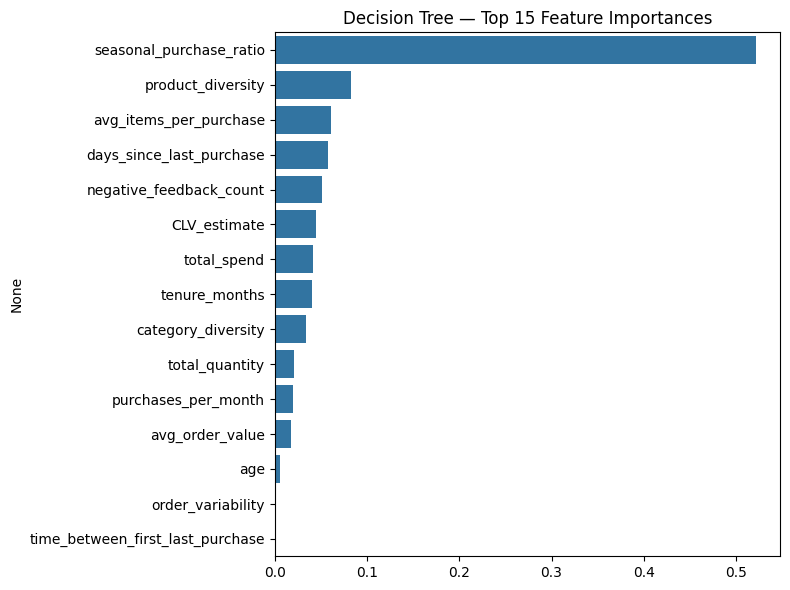

In [75]:
dt = DecisionTreeClassifier(
    max_depth=6,            # try 4–10
    min_samples_leaf=20,    # helps generalization
    random_state=42
)
dt.fit(X_train_res_num, y_train_res)

# Predict + metrics
y_pred_dt = dt.predict(X_test_num)
y_proba_dt = dt.predict_proba(X_test_num)[:, 1]

print("=== Decision Tree (SMOTE) ===")
print(classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("ROC AUC:", roc_auc_score(y_test, y_proba_dt))

# Optional: feature importance
fi_dt = pd.Series(dt.feature_importances_, index=num_cols).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=fi_dt.values[:15], y=fi_dt.index[:15])
plt.title("Decision Tree — Top 15 Feature Importances")
plt.tight_layout()
plt.show()


#Random forests

=== Random Forest (SMOTE) ===
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       288
           1       0.32      0.19      0.24        95

    accuracy                           0.70       383
   macro avg       0.54      0.53      0.52       383
weighted avg       0.65      0.70      0.67       383

Confusion Matrix:
 [[249  39]
 [ 77  18]]
ROC AUC: 0.5390350877192982


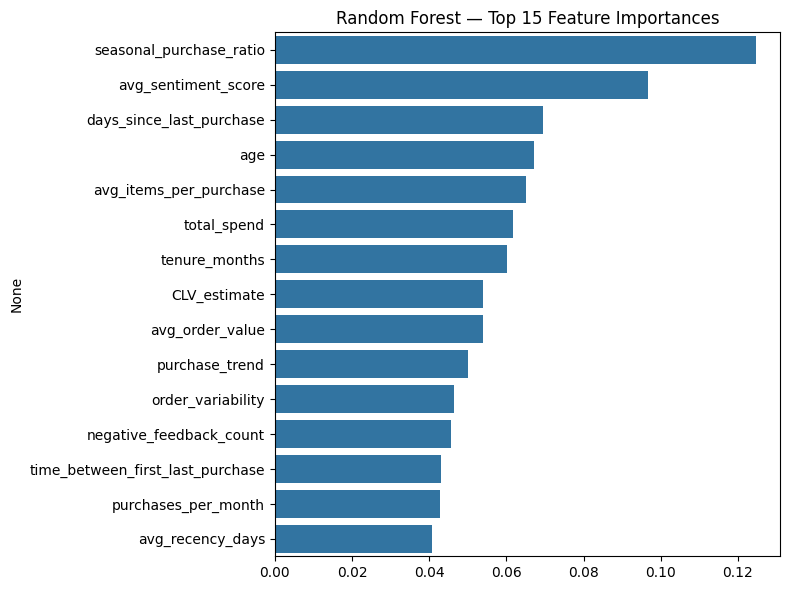

In [76]:

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,          # let trees grow; you can cap (e.g., 12) if overfitting
    min_samples_leaf=10,     # regularization
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train_res_num, y_train_res)

# Predict + metrics
y_pred_rf = rf.predict(X_test_num)
y_proba_rf = rf.predict_proba(X_test_num)[:, 1]

print("=== Random Forest (SMOTE) ===")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))

# Optional: feature importance
fi_rf = pd.Series(rf.feature_importances_, index=num_cols).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=fi_rf.values[:15], y=fi_rf.index[:15])
plt.title("Random Forest — Top 15 Feature Importances")
plt.tight_layout()
plt.show()


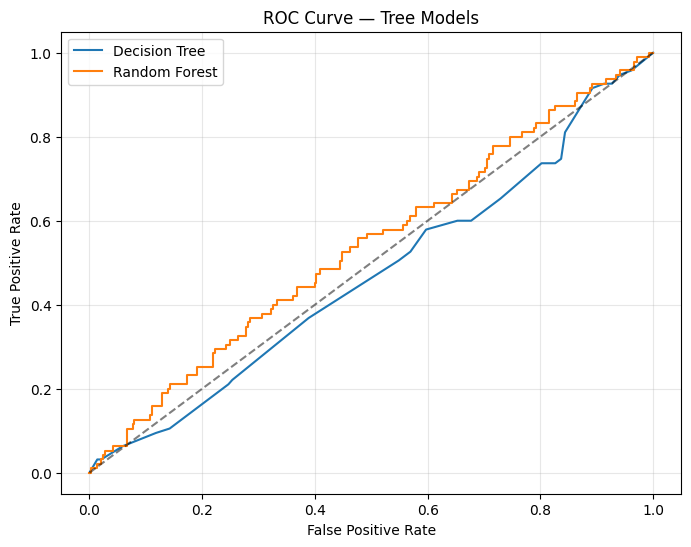

In [77]:

plt.figure(figsize=(8,6))
# If you have y_proba from Logistic (SMOTE), you can plot it too:
# fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr_smote)
# plt.plot(fpr_lr, tpr_lr, label=f"LogReg (SMOTE)")

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.plot(fpr_dt, tpr_dt, label="Decision Tree")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0,1],[0,1],"k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Tree Models")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


=== Random Forest (no SMOTE) ===
              precision    recall  f1-score   support

           0       0.75      0.90      0.82       288
           1       0.25      0.11      0.15        95

    accuracy                           0.70       383
   macro avg       0.50      0.50      0.48       383
weighted avg       0.63      0.70      0.65       383

Confusion Matrix:
 [[258  30]
 [ 85  10]]
ROC AUC: 0.527046783625731


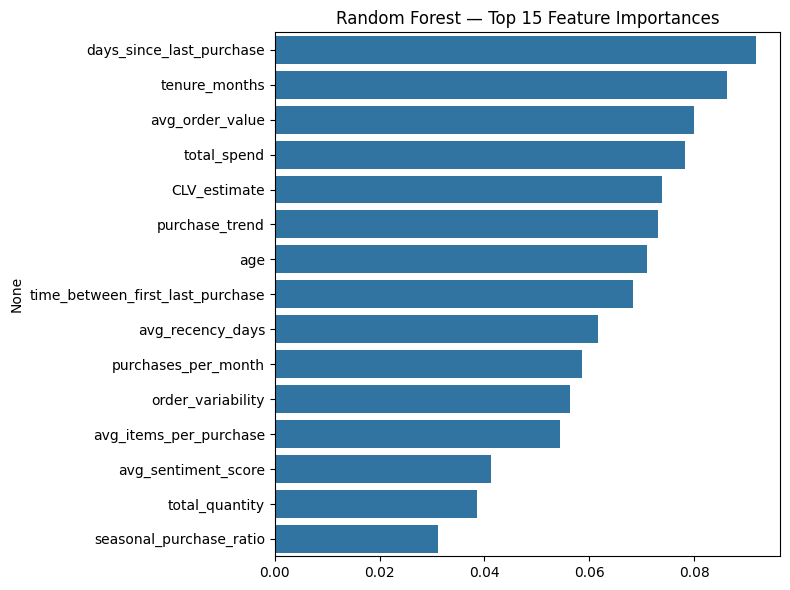

In [78]:

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,          # or cap (e.g., 12) if overfitting
    min_samples_leaf=10,     # regularization
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("=== Random Forest (no SMOTE) ===")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))

# Feature importance (top 15)
fi_rf = pd.Series(rf.feature_importances_, index=num_cols).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=fi_rf.values[:15], y=fi_rf.index[:15])
plt.title("Random Forest — Top 15 Feature Importances")
plt.tight_layout()
plt.show()


In [79]:
with open('../models/churn_model.pkl','wb') as f:
    pickle.dump(rf,f)

In [57]:
X.columns

Index(['total_spend', 'total_quantity', 'avg_order_value',
       'avg_items_per_purchase', 'avg_recency_days',
       'days_since_last_purchase', 'time_between_first_last_purchase',
       'order_variability', 'purchases_per_month', 'product_diversity',
       'category_diversity', 'seasonal_purchase_ratio', 'avg_sentiment_score',
       'negative_feedback_count', 'purchase_trend', 'CLV_estimate', 'age',
       'tenure_months'],
      dtype='object')